In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
# Open the zip file
with zipfile.ZipFile('/content/drive/MyDrive/FER13_4_cleaner.zip', 'r') as zip_ref:
    # Extract all the files to the current directory
    zip_ref.extractall()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

# **Visualizing Classes**

In [4]:
import os
import pandas as pd

def Classes_Count(path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)
        if os.path.isdir(Full_Path):  # Check if it's a directory
            Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

# Set the directories
train_dir = '/content/FER13_cleaner/train'
test_dir = '/content/FER13_cleaner/test'

# Count classes
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

# Display the counts
print("Train Counts:")
print(Train_Count)
print("\nTest Counts:")
print(Test_Count)


Train Counts:
         Train
happy     6834
sad       4685
neutral   4295
angry     2832

Test Counts:
         Test
happy    1770
sad      1245
neutral  1233
angry     955


In [5]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,6834,1770
sad,4685,1245
neutral,4295,1233
angry,2832,955


<Axes: >

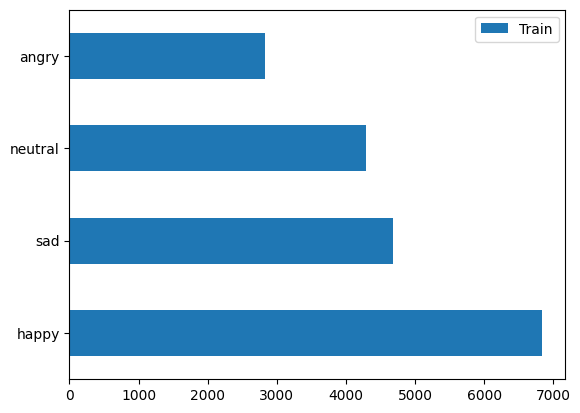

In [6]:
Train_Count.plot(kind='barh')

<Axes: >

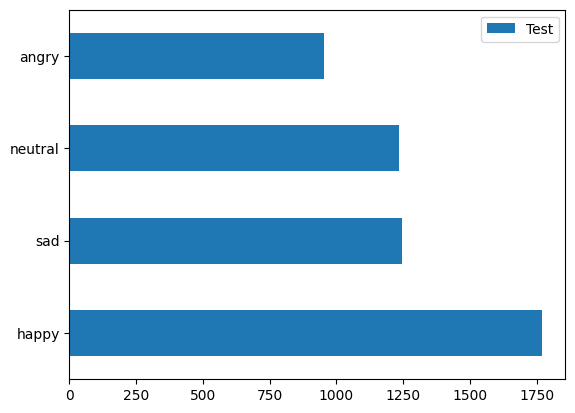

In [7]:
Test_Count.plot(kind='barh')

In [9]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '/content/FER13_cleaner/train'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 4, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

FileNotFoundError: [Errno 2] No such file or directory: '/content/FER13_cleaner/trainangry'

<Figure size 2500x800 with 0 Axes>

# **Data Preprocessing**

In [10]:
img_shape = 48
batch_size = 64
train_data_path = '/content/FER13_cleaner/train'
test_data_path = '/content/FER13_cleaner/test'

In [11]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 18646 images belonging to 4 classes.
Found 5203 images belonging to 4 classes.


# **Building CNN Model**

In [12]:
def Create_CNN_Model():

    model = Sequential()

    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))


    #Output
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(4,activation='softmax'))


    return model

In [13]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                        

**Specifying Callbacks**

In [14]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [15]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=80, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/80
291/291 [==============================] - 50s 118ms/step - loss: 1.5666 - accuracy: 0.3160 - val_loss: 1.6202 - val_accuracy: 0.3414 - lr: 0.0010
Epoch 2/80
291/291 [==============================] - 31s 106ms/step - loss: 1.3698 - accuracy: 0.3601 - val_loss: 1.2784 - val_accuracy: 0.4213 - lr: 0.0010
Epoch 3/80
291/291 [==============================] - 30s 103ms/step - loss: 1.2660 - accuracy: 0.4285 - val_loss: 1.1671 - val_accuracy: 0.4738 - lr: 0.0010
Epoch 4/80
291/291 [==============================] - 30s 103ms/step - loss: 1.1719 - accuracy: 0.4742 - val_loss: 1.1807 - val_accuracy: 0.4759 - lr: 0.0010
Epoch 5/80
291/291 [==============================] - ETA: 0s - loss: 1.0947 - accuracy: 0.5163
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
291/291 [==============================] - 34s 116ms/step - loss: 1.0947 - accuracy: 0.5163 - val_loss: 1.2784 - val_accuracy: 0.4614 - lr: 0.0010
Epoch 6/80
291/291 [============================

In [16]:
# Menyimpan model dalam format HDF5
CNN_Model.save('model_optimal.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Evaluating CNN Model**

In [17]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

82/82 [==============================] - 2s 28ms/step - loss: 0.7738 - accuracy: 0.6775
    Test Loss: 0.77383
Test Accuracy: 67.75%


In [18]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

  #plt.tight_layout()

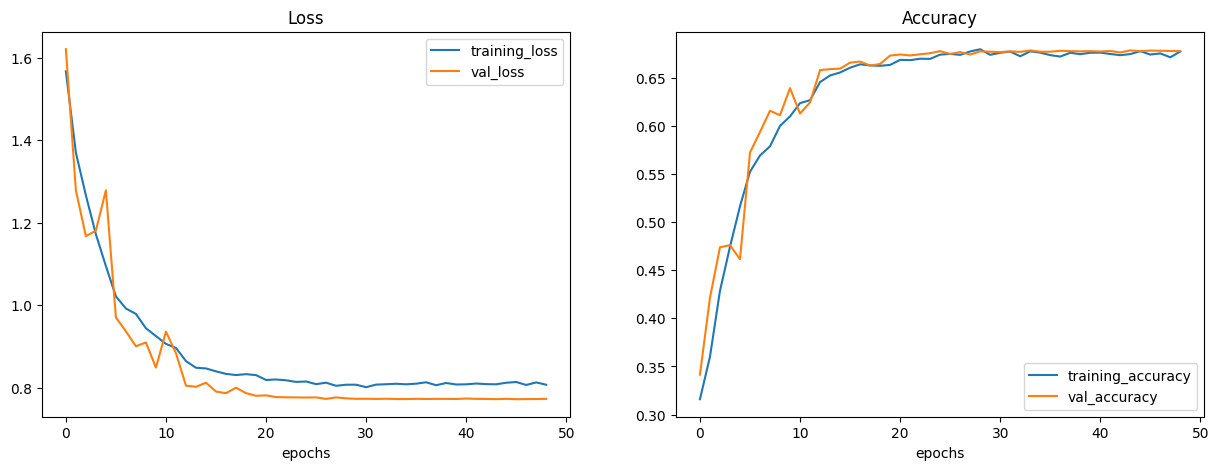

In [19]:
plot_curves(CNN_history)

In [20]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

82/82 [==============================] - 2s 23ms/step


In [21]:
test_data.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

Text(0.5, 1.0, 'CNN Confusion Matrix')

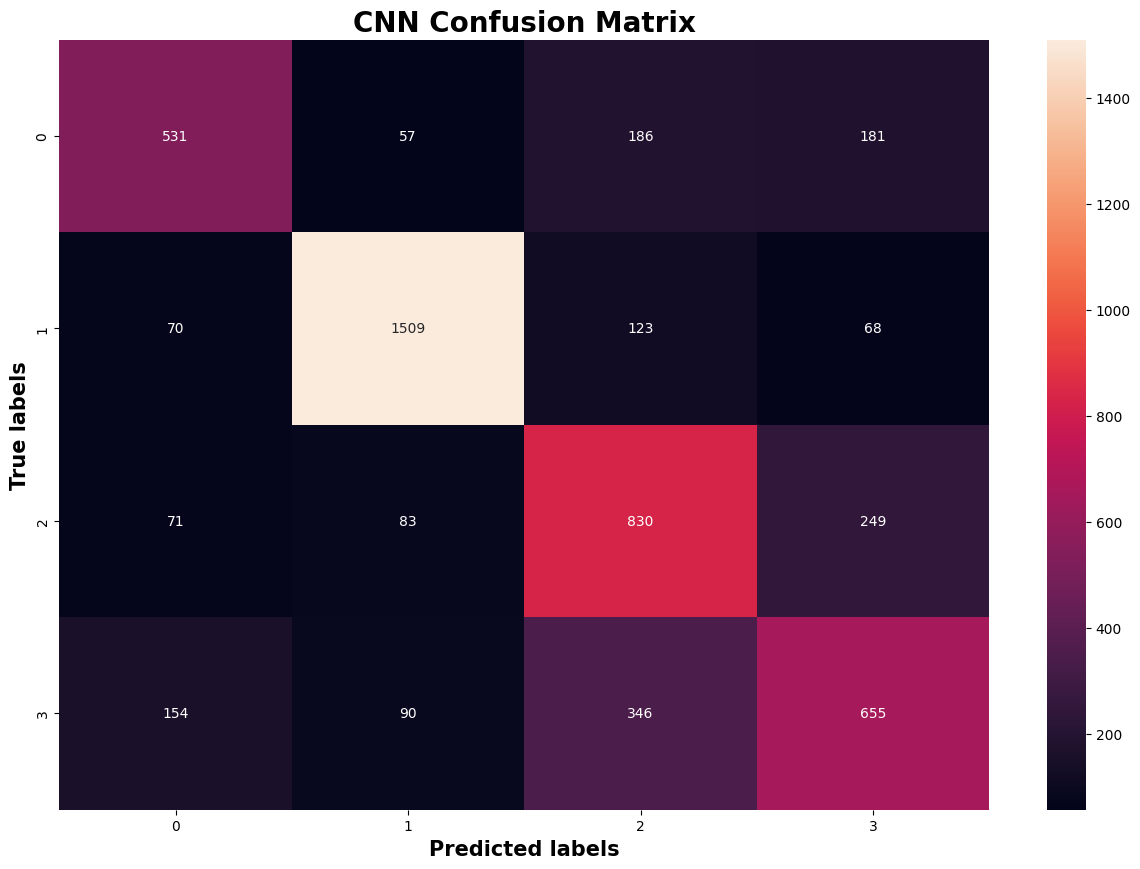

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

In [23]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 18646 images belonging to 4 classes.
Found 5203 images belonging to 4 classes.


**Specifying Callbacks**

# **Visualizing Predictions**

In [24]:
Emotion_Classes = ['Angry',
                  'Happy',
                  'Neutral',
                  'Sad',]

In [25]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 5203 images belonging to 4 classes.


**CNN Predictions**

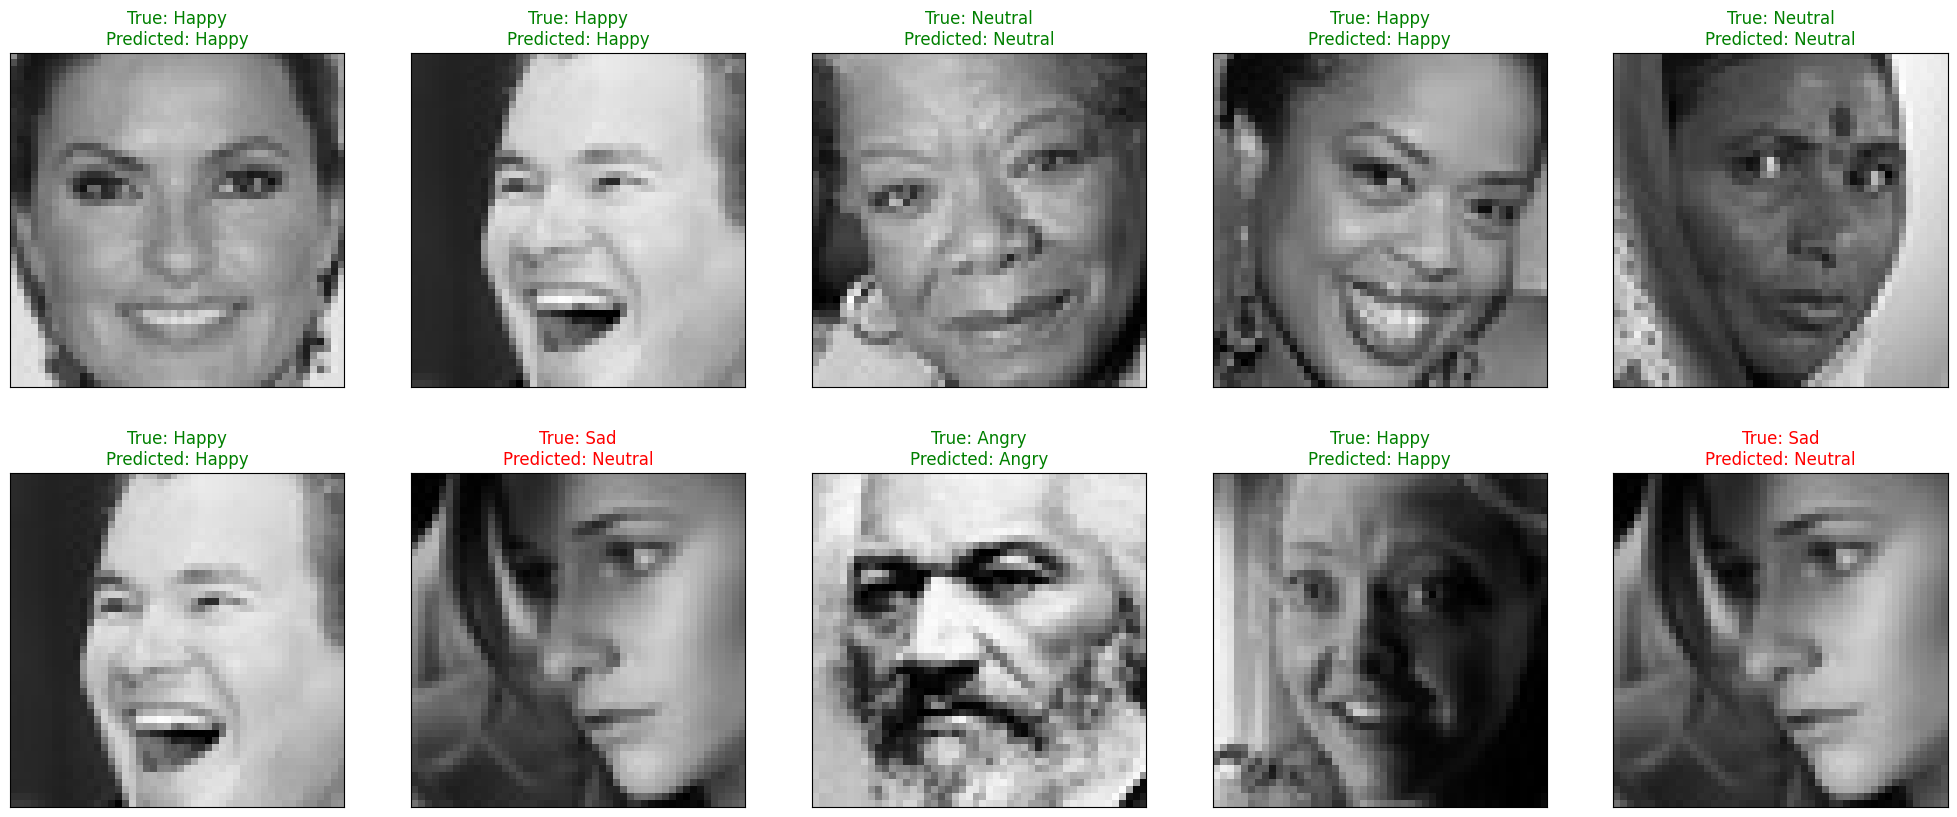

<Figure size 640x480 with 0 Axes>

In [26]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [27]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

--2024-06-13 21:27:14--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.007s  

2024-06-13 21:27:14 (129 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [28]:
def load_and_prep_image(filename, img_shape = 224):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)

    for x,y,w,h in faces:

        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]

        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)

        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [29]:
def pred_and_plot(filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = ResNet50V2_Model.predict(np.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[pred.argmax()]

    # Plot the image and predicted class
    #plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

    Recommend_Songs(pred_class)

NameError: name 'ResNet50V2_Model' is not defined

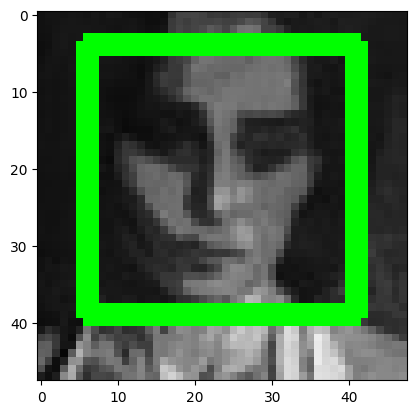

In [37]:
pred_and_plot("/content/FER13_cleaner/test/sad/PrivateTest_13472479.jpg", Emotion_Classes) # with CNN

In [31]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg" -O sad.jpg

--2024-06-13 21:27:27--  https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.237.101, 2606:2800:248:1707:10d3:19d0:1ba2:1a23
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.237.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36922 (36K) [image/jpeg]
Saving to: ‘sad.jpg’

sad.jpg             100%[===================>]  36.06K  --.-KB/s    in 0.001s  

2024-06-13 21:27:27 (45.9 MB/s) - ‘sad.jpg’ saved [36922/36922]



In [38]:
pred_and_plot("/content/happy.jpg", Emotion_Classes) # with CNN

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [33]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/profile_images/758370732413947904/xYB5Q3FY_400x400.jpg" -O happy.jpg

--2024-06-13 21:27:33--  https://pbs.twimg.com/profile_images/758370732413947904/xYB5Q3FY_400x400.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.237.101, 2606:2800:248:1707:10d3:19d0:1ba2:1a23
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.237.101|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-06-13 21:27:34 ERROR 404: Not Found.



In [34]:
CNN_Model.save("CNN_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
CNN_Model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
import tensorflow as tf

# Langkah 1: Memuat model dari file .h5
model = tf.keras.models.load_model('model_optimal.h5')

# Langkah 2: Mengonversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Langkah 3: Menyimpan model yang telah dikonversi ke file .tflite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [45]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('CNN_Model.h5')

# Check the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                        

Saving WhatsApp Image 2024-06-14 at 05.08.38.jpeg to WhatsApp Image 2024-06-14 at 05.08.38 (9).jpeg
1/1 [==============================] - 0s 275ms/step
WhatsApp Image 2024-06-14 at 05.08.38 (9).jpeg


KeyError: 2

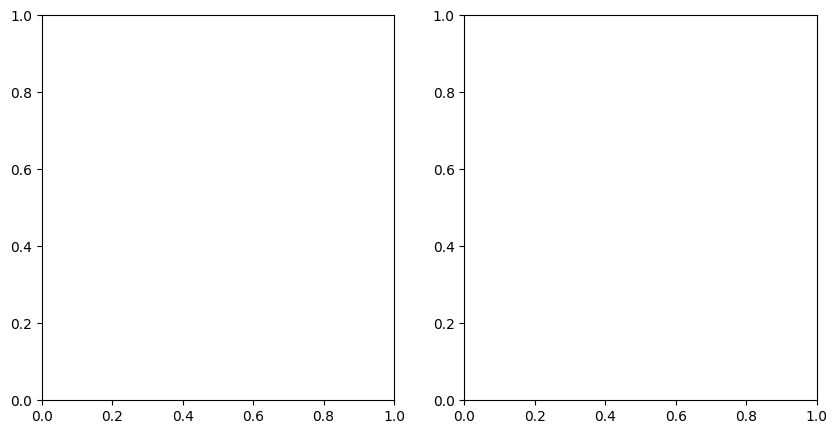

In [55]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

uploaded = files.upload()

class_labels = {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

# Set up the subplots
fig, ax = plt.subplots(nrows=len(uploaded), ncols=2, figsize=(10, len(uploaded)*5))

for i, fn in enumerate(uploaded.keys()):
  # predict images
  path = fn
  img_source = image.load_img(path, target_size = (48, 48))
  x = image.img_to_array(img_source)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(fn)

  # Use argmax to find the index of the predicted class
  predicted_class_index = np.argmax(classes[0])

  # Use the class_labels dictionary to get the corresponding label
  predicted_class = class_labels[predicted_class_index]

  print(predicted_class)

  # Display the image on the left side
  ax[i, 0].imshow(img_source)
  ax[i, 0].axis('off')  # Turn off axis labels

  # Bar plot of class probabilities on the right side
  class_probabilities = classes[0]
  ax[i, 1].barh(list(class_labels.values()), class_probabilities)
  ax[i, 1].set_xlim([0, 1])  # Set y-axis limit to match probability range
  ax[i, 1].set_xlabel('Probability')
  ax[i, 1].set_title('Class Probabilities')

  # Print the predicted class label
  ax[i, 1].text(1.1, 0.5, f'Predicted: {predicted_class}', transform=ax[i, 1].transAxes, fontsize=12,
                verticalalignment='center')